# Two-agent Fixed Priority Path Planning

In [1]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env

import shapely
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

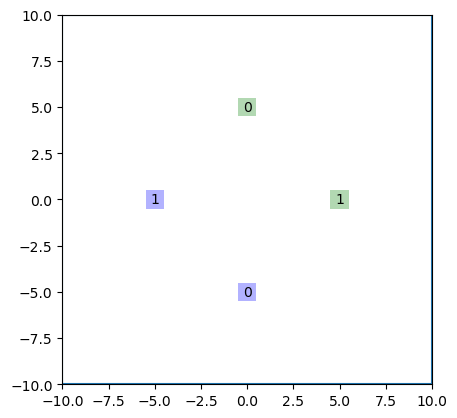

In [2]:

start_locs = np.array([[0,-5],[-5,0]])
goal_locs = np.array([[0,5],[5,0]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]


limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[],starts,goals)

draw_env(env)

In [3]:
from panav.SAMP import SA_MILP_Planning
from panav.util import unique_tx, interpolate_positions

In [4]:
from panav.env import line_seg_to_obstacle

In [48]:
go_agent = 0
yield_agent = 1

bloating_r = 0.5

d = 2
K = 10
t0 = 0
vmax = 10.0
interp_dt = 0.1

In [26]:
temp_obstacles = []
# for k in range(xs.shape[-1]-1):
#     temp_obstacles.append(([times[k],times[k+1]], line_seg_to_obstacle(xs[:,k],xs[:,k+1],bloating_r)))
# # env.obstacles+=[o for (_,o) in temp_obs]

for k in range(x.value.shape[-1]-1):
    env.obstacles.append(line_seg_to_obstacle(x.value[:,k],x.value[:,k+1],bloating_r))


In [6]:
import cvxpy as cp

In [70]:
# # Planning for the agent with lower priority
start = env.starts[yield_agent]
goal = env.goals[yield_agent]

# Planning for the agent with higher priority
# start = env.starts[go_agent]
# goal = env.goals[go_agent]

M = 100 * np.max(np.abs(env.limits))
    
x = cp.Variable((d, K+1))
t = cp.Variable(K+1)

constraints = []

# Boundary constraints
constraints.append(x <= np.array(env.limits)[:,-1].reshape(-1,1) - 3*bloating_r)
constraints.append(x >= np.array(env.limits)[:,0].reshape(-1,1) + 3* bloating_r)

# Start and goal constraints
constraints.append(start.A @ x[:,0] <= start.b)
constraints.append(goal.A @ x[:,-1] <= goal.b)


# Static obstacle constraints
obs = [([],O) for O in env.obstacles] + temp_obstacles
lb_active = []
ub_active = []
for duration,O in obs:
    A, b= O.A,O.b
    # print(A,b,O.vertices())

    H = A @ x-(b+ np.linalg.norm(A) * bloating_r).reshape(-1,1) # Bloating radius

    alpha = cp.Variable((H.shape[0],K),boolean=True)

    constraints.append(H[:,1:] + M * (1-alpha)>=0)
    constraints.append(H[:,:-1] + M * (1-alpha)>=0)

    constraints.append(cp.sum(alpha,axis = 0)>=1)
    


# Time positivity constraint
constraints.append(t[0]==t0)
constraints.append(t[1:]>=t[:-1])

# Velocity constraints
vb = vmax*(t[1:]-t[:-1])
for i in range(d):
    diff = x[i,1:]-x[i,:-1]
    constraints.append(cp.abs(diff)+1e-5<=vb )
    # constraints.append(np.sqrt(2) * diff +1e-5<= vb)
    # constraints.append(- vb +1e-5<= np.sqrt(2) * diff)

prob = cp.Problem(cp.Minimize(t[-1]),constraints)

prob.solve(solver='GUROBI',verbose=True,eps=1e-10,abstol=1e-8)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Mar 31 11:24:43 AM: Your problem has 433 variables, 38 constraints, and 0 parameters.
(CVXPY) Mar 31 11:24:43 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 31 11:24:43 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 31 11:24:43 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


SolverError: The solver GUROBI is not installed.

In [64]:
constraints[-1].value()

False

In [65]:
constraints[0].value()

True

In [66]:
x.value

array([[-5.5    , -8.5    , -8.5    , -8.5    , -8.5    , -8.5    ,
        -8.5    , -8.5    , -8.5    ,  1.5    ,  4.5    ],
       [-0.5    , -4.06206, -8.5    , -8.5    , -8.5    , -8.5    ,
        -8.5    , -8.5    , -8.5    , -5.00542, -0.5    ]])

In [67]:
t.value

array([ 0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.])

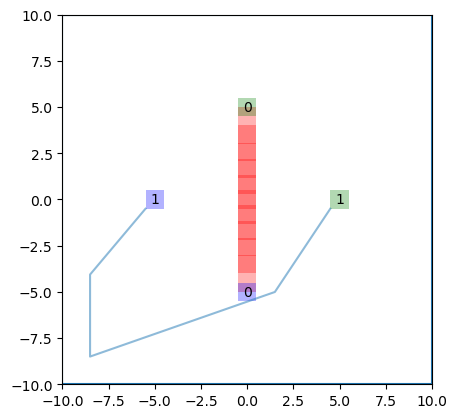

In [68]:
draw_env(env,[x.value])

In [64]:
t2,x2 = unique_tx(t2,x2)

In [82]:
for i in range(2):
    print(x2[i,1:]-x2[i,:-1])

[-3.  0.  0.  0.  0.  0.  0.  0.  0. 13.]
[-8.  0.  0.  0.  0.  0.  0.  0.  0.  8.]


In [79]:
t2

array([ 0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

TypeError: 'NoneType' object is not subscriptable

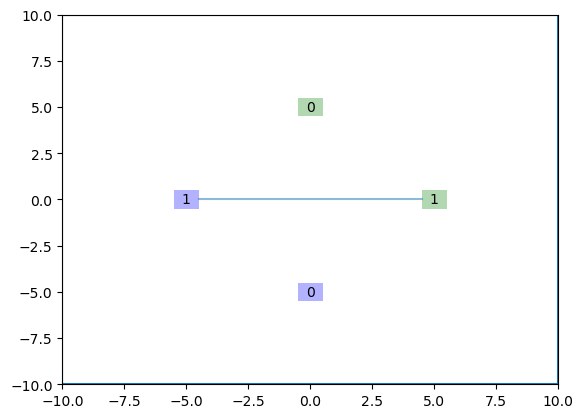

In [56]:
draw_env(env,[xs,x2])

# Animation

In [10]:
from panav.viz import animation
from IPython.display import HTML, display

In [11]:
anim = animation(env, pos, bloating_r, dt = interp_dt / 4)
display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.